In [1]:
# Import of main modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import total_ordering
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score
from sklearn.feature_selection import RFE

In [2]:
%matplotlib inline

In [3]:
# Importing data
# In this case read_csv method was used to read .txt file.
# This method is very powerful to deal with as many problems as we can imagine!
# Parameter sep was set to tab ('\t')
uscrime_df = pd.read_csv('./dataset/uscrime.txt', sep='\t')

# Exploratory data analysis

At first, the `.head ()`, `.info ()` and `.describe ()` methods will be used.

- .head () -> It brings some entries from the original dataset, it receives as parameter the number of lines that you want to view, by default `n = 5`.

In [4]:
uscrime_df.head()

,M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1,U2,Wealth,Ineq,Prob,Time,Crime
0,15.1,1,9.1,5.8,5.6,0.510,95.0,33,30.1,0.108,4.1,3940,26.1,0.084602,26.2011,791
1,14.3,0,11.3,10.3,9.5,0.583,101.2,13,10.2,0.096,3.6,5570,19.4,0.029599,25.2999,1635
2,14.2,1,8.9,4.5,4.4,0.533,96.9,18,21.9,0.094,3.3,3180,25.0,0.083401,24.3006,578
3,13.6,0,12.1,14.9,14.1,0.577,99.4,157,8.0,0.102,3.9,6730,16.7,0.015801,29.9012,1969
4,14.1,0,12.1,10.9,10.1,0.591,98.5,18,3.0,0.091,2.0,5780,17.4,0.041399,21.2998,1234


- .info () -> returns important information about the dataset, such as the number of entries, estimation of missing data in each column, the type of each column and the memory used for allocating the dataframe.

Note: By default, the numerical features in pandas allocate 32 or 64 bits (`float64` or` float32` and ʻint64` or ʻint32`), it is interesting, in the case of working with larger data sets that do not need this space in memory, to change the types of variables to `float16` and ʻint8`. This change is able to save a huge amount of memory.

In [5]:
uscrime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   M       47 non-null     float64
 1   So      47 non-null     int64  
 2   Ed      47 non-null     float64
 3   Po1     47 non-null     float64
 4   Po2     47 non-null     float64
 5   LF      47 non-null     float64
 6   M.F     47 non-null     float64
 7   Pop     47 non-null     int64  
 8   NW      47 non-null     float64
 9   U1      47 non-null     float64
 10  U2      47 non-null     float64
 11  Wealth  47 non-null     int64  
 12  Ineq    47 non-null     float64
 13  Prob    47 non-null     float64
 14  Time    47 non-null     float64
 15  Crime   47 non-null     int64  
dtypes: float64(12), int64(4)
memory usage: 6.0 KB


- .describe () -> Calculation of several relevant statistics for numerical variables such as average, median, minimum and maximum values, among others.

In [6]:
# I used rounding to facilitate data visualization, remembering that as pandas is based on numpy operations
# are easily applicable to all dataframe values.

round(uscrime_df.describe(), 3)

,M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1,U2,Wealth,Ineq,Prob,Time,Crime
count,47.000,47.000,47.000,47.000,47.000,47.000,47.000,47.000,47.000,47.000,47.000,47.000,47.00,47.000,47.000,47.000
mean,13.857,0.340,10.564,8.500,8.023,0.561,98.302,36.617,10.113,0.095,3.398,5253.830,19.40,0.047,26.598,905.085
std,1.257,0.479,1.119,2.972,2.796,0.040,2.947,38.071,10.283,0.018,0.845,964.909,3.99,0.023,7.087,386.763
min,11.900,0.000,8.700,4.500,4.100,0.480,93.400,3.000,0.200,0.070,2.000,2880.000,12.60,0.007,12.200,342.000
25%,13.000,0.000,9.750,6.250,5.850,0.530,96.450,10.000,2.400,0.080,2.750,4595.000,16.55,0.033,21.600,658.500
50%,13.600,0.000,10.800,7.800,7.300,0.560,97.700,25.000,7.600,0.092,3.400,5370.000,17.60,0.042,25.801,831.000
75%,14.600,1.000,11.450,10.450,9.700,0.593,99.200,41.500,13.250,0.104,3.850,5915.000,22.75,0.054,30.451,1057.500
max,17.700,1.000,12.200,16.600,15.700,0.641,107.100,168.000,42.300,0.142,5.800,6890.000,27.60,0.120,44.000,1993.000


# Inconsistencies in the types of variables

Observing the description of the variables, their data structures and the values ​​of the statistics, it is observed that we have an inconsistency with the `So` feature. This is a categorical feature, which indicates whether the entry is from a southern state or not, so calculations such as average, standard deviation and quartiles do not make much sense. In this case, it is necessary to make a change in the type of the variable to categorical and apply the .describe () method again. It will be possible to observe an adaptation of pandas to treat this type of data.

In [7]:
# method .astype() to transform data type to category
uscrime_df[['So']].astype('category').describe()

,So
count,47
unique,2
top,0
freq,31


Changing the data type to categorical, we can observe the change in the statistics calculated by the `.describe ()` method, I can now analyze how many unique values ​​the variable has (in this case, 0 and 1), which is the most frequent value ( top = 0) and its frequency (31 occurrences in 47, approximately 65.96%).
As noted, there are only two categories for this variable, so I will keep this column as an integer type, since it can be used as a feature in the development of the predictive model.
In cases where more category options occur, we can use methodologies such as ʻone hot encoding` or `get_dummies` to transform these features into numeric features, where new columns would be created in the data frame, each representing a category (remembering to create n-1 new columns so that there is no redundancy affecting the model's performance). The idea of ​​this methodology is that when creating numerical categories, the prediction models do not consider higher numbers as more important and with the creation of a column for each category, I guarantee that the possible values ​​are only 1 (if it belongs to the category) and 0 (if not).

# Treatment of Missing Data

This is a very important stage of exploratory data analysis, in this case there is no occurrence of missing data, but if there were, we would have to think about a strategy to treat them. Here are some possibilities:

- If there is a small amount in relation to the total volume of data, I can simply delete the entries with missing data (remembering that the definition of what would be 'little significant' varies from case to case).
- We can use statistics to fill in, such as average, median, minimum and maximum values.
- We can use a business rule to fill out.
- We can rely on other variables to obtain these values, both through direct relationships and through predictive models.

Anyway, there are probably other ways to analyze and fill in missing data, this being a peculiar analysis of each data set.

In [8]:
# As a quick analysis of the presence or absence of missing data, I can run the following line of code:

has_nan = any(uscrime_df.isna().sum())
print(f"Is there any missing value? -> {'Yes' if has_nan else 'No'}")

Is there any missing value? -> No


# Analysis of correlation between variables

One effective way to observe how variables are related is to analyze the correlation between them. Pandas already has a native .corr () method that when applied to the data frame, returns how the numeric variables relate to each other.

In [9]:
# In this case, I created a new data frame to receive the correlation between variables

uscrime_correlation_df = round(uscrime_df.corr(), 3)
uscrime_correlation_df

,M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1,U2,Wealth,Ineq,Prob,Time,Crime
M,1.000,0.584,-0.530,-0.506,-0.513,-0.161,-0.029,-0.281,0.593,-0.224,-0.245,-0.670,0.639,0.361,0.115,-0.089
So,0.584,1.000,-0.703,-0.373,-0.376,-0.505,-0.315,-0.050,0.767,-0.172,0.072,-0.637,0.737,0.531,0.067,-0.091
Ed,-0.530,-0.703,1.000,0.483,0.499,0.561,0.437,-0.017,-0.665,0.018,-0.216,0.736,-0.769,-0.390,-0.254,0.323
Po1,-0.506,-0.373,0.483,1.000,0.994,0.121,0.034,0.526,-0.214,-0.044,0.185,0.787,-0.631,-0.473,0.103,0.688
Po2,-0.513,-0.376,0.499,0.994,1.000,0.106,0.023,0.514,-0.219,-0.052,0.169,0.794,-0.648,-0.473,0.076,0.667
LF,-0.161,-0.505,0.561,0.121,0.106,1.000,0.514,-0.124,-0.341,-0.229,-0.421,0.295,-0.270,-0.250,-0.124,0.189
M.F,-0.029,-0.315,0.437,0.034,0.023,0.514,1.000,-0.411,-0.327,0.352,-0.019,0.180,-0.167,-0.051,-0.428,0.214
Pop,-0.281,-0.050,-0.017,0.526,0.514,-0.124,-0.411,1.000,0.095,-0.038,0.270,0.308,-0.126,-0.347,0.464,0.337
NW,0.593,0.767,-0.665,-0.214,-0.219,-0.341,-0.327,0.095,1.000,-0.156,0.081,-0.590,0.677,0.428,0.230,0.033
U1,-0.224,-0.172,0.018,-0.044,-0.052,-0.229,0.352,-0.038,-0.156,1.000,0.746,0.045,-0.064,-0.007,-0.170,-0.050


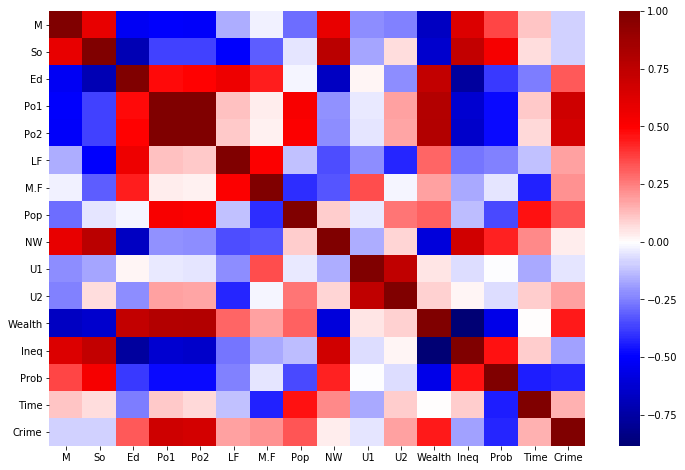

In [10]:
# Generation of the heat map for the correlations between numerical variables in the data frame.

plt.figure(figsize=(12, 8))
sns.heatmap(uscrime_correlation_df, center=0, cmap='seismic');

In [11]:
correlation_with_crime = uscrime_correlation_df.loc['Crime'][uscrime_correlation_df.columns != 'Crime']
correlation_with_crime

M        -0.089
So       -0.091
Ed        0.323
Po1       0.688
Po2       0.667
LF        0.189
M.F       0.214
Pop       0.337
NW        0.033
U1       -0.050
U2        0.177
Wealth    0.441
Ineq     -0.179
Prob     -0.427
Time      0.150
Name: Crime, dtype: float64

# Important notes:

Considering the correlations and heat map, it is observed that the variables `Po1` and` Po2` are those that have the highest correlations with the target variable (respectively 0.688 and 0.667), it is also observed that these variables have a correlation of almost 1 among them (0.994), this means that I can use only one of them in my predictive model, thus reducing the dimension of the problem. In this case, I will use the variable `Po1` which has the highest correlation with the target variable.
The variables `M`,` So`, `NW` and ʻU1` show correlations less than 0.1 and -0.1 so they will not be considered in the development of the predictive model.
In this step, I will use object-oriented development to develop the predictive model, the idea is that with this modeling, it is possible to create and compare models, in order to obtain the best possible model considering the adopted criteria.

# Development of the CrimeRatePredictor class

This class will be used to abstract all stages of the development of the prediction model, the idea is to make a development focused on reusability, scalability and maintenance. Also making a good definition of each method, it is possible to perform unit tests in a very simple and direct way.

I will comment a little on the most important methods of this class:

- `feature_selection ()` - This method defines which features will be used in the predictive model. At first, I used the correlation analysis, taking as a parameter a cut factor.

- `transform_data_with_selected_features ()` - This method applies the features selected in the data frame, obtaining the specific data frame that will be used in the predictive model. There is also a static method that will be used to transform new data.

- `split_data_into_train_test_part ()` - Method used to partition the original data into training data and test data so that I can validate the model by calculating metrics that can be compared.

- `fit_model_to_predict ()` - Method responsible for calibrating the model. At first I used linear regression.

- `make_predictions_with_test_data ()` - Method responsible for calculating predicting results using test data in order to be used in the calculation of validation metrics.

- `calculate_model_metric ()` - This function calculates the evaluation metrics of the models using the predictions of the test data. The calculated metric is allocated to an attribute, this attribute will be used in the ordering methods, allowing objects of the class to be ordered when arranged in a collection.

- `@ total_ordering`,` __eq __ () `and` __lt __ () `- Define methods that allow objects of this class to be sorted according to some specific criteria. In this case I will use the metric.


# Metric used: explained_variance_score:

This metric explains the dispersion of errors in a given data set. The closer to 1, the better the model, indicating better squares of the standard deviations of the errors.

[referencia 1:](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.explained_variance_score.html#sklearn.metrics.explained_variance_score)  
[referencia 2:](https://books.google.com.br/books?id=7S6WDwAAQBAJ&pg=PA332&lpg=PA332&dq=explained_variance_score&source=bl&ots=awF03vf-ai&sig=ACfU3U0TjsTsxfY6KxJfUFuHEUGpR3IM4w&hl=pt-BR&sa=X&ved=2ahUKEwiS2M3TqK_qAhXmGbkGHaNAB4oQ6AEwDnoECAoQAQ#v=onepage&q=explained_variance_score&f=false)

In [12]:
@total_ordering
class CrimeRatePredictor(object):
    """
    This class will be used as a model for specific child classes for each considered predictive model.
    """
    
    def __init__(self, crime_df):
        
        # This class will delete 'Po2' from original data frame once we decided didn't consider it in our analysis.
        self.crime_df = crime_df.copy()
        del (self.crime_df['Po2'])
        
        # List of features that will be used according some criteria
        self.corr_factor = 0
        self.features_to_use = []
        
        # Target name in case of use it in other methods
        self.target_name = 'Crime'
        
        # Complete data from target variable
        self.target_data = self.crime_df[self.target_name]
        
        # Attribute to allocate complete data 
        self.complete_x_data = self.crime_df.drop(columns='Crime')
        
        # Attributes that will be used into train x test split
        self.x_train = 'This attribute is not defined yet'
        self.x_test = 'This attribute is not defined yet'
        self.y_train = 'This attribute is not defined yet'
        self.y_test = 'This attribute is not defined yet'
        
        # Number that ensures that the numerical experiment can be reproduced.
        self.random_seed = 42
        
        # Infos about prediction model.
        self.model_name = 'Linear Regression'
        self.model = LinearRegression()
        self.model_metric = 'This attribute is not defined yet'
        
        # Values predicted using x_test to validate the model.
        self.y_test_pred = 'This attribute is not defined yet'

    
    @property
    def model_info(self):
        
        complete_info =  f"Model: {self.model_name} "
        complete_info += '-> '
        complete_info += f'Correlation Factor: {self.corr_factor} '
        complete_info += '-> '
        complete_info += f'Number of features used: {len(self.features_to_use)} '
        complete_info += '-> '
        complete_info += f'Metric - Explained Variance Score: {round(self.model_metric, 3)}'
        return complete_info
    
    @property
    def print_shape(self):
        """
        Method to print the number of rows and columns.
        """
        print(f'Number of lines: {self.crime_df.shape[0]}')
        print(f'Number of columns: {self.crime_df.shape[1]}')
        
    @property
    def print_column_names(self):
        """
        Method to print column names of the original data frame.
        """
        print('Column names:')
        
        for column in self.crime_df.columns:
            
            print(f'             {column} - type: {self.crime_df[column].dtype}')
        
    def show_dataframe_information(self):
        """
        Show information about data frame used to develop this model.
        """
        print('========= Start Data Frame Information ==========')
        print('\n')
        self.print_shape
        self.print_column_names
        print('\n')
        print('========= Finish Data Frame Information ==========')
        
   
    def feature_selection(self, corr_factor: float) -> list:
        """
        Method based on a correlation factor to decide which features will be used to implement a predictive model.
        
        args:
        
            corr_factor: float -> factor that will be used to select most influent features. In this case, features that
                                  presents correlation with target greater than corr_factor or less than (-corr_factor).
                                  
        return: 
            
            self.features_to_use: list -> List of features that will be used defined by corr_factor criteria.
        """
        
        self.corr_factor = corr_factor
        # Create the correlational data frame.
        crime_df_corr = self.crime_df.corr()
        
        # Obtain the conditional to filter the correlation data frame considering the corr_factor
        evaluate_corr_factor_conditional = (crime_df_corr[self.target_name] >= corr_factor) \
                                           | (crime_df_corr[self.target_name] <= -corr_factor)
        
        # Select all features that achieve the corr_factor test.
        self.features_to_use = crime_df_corr[evaluate_corr_factor_conditional].index
        
        # Drop target column (Crime) and transform to list.
        self.features_to_use = self.features_to_use.drop(self.target_name).tolist()
        
        return self.features_to_use
        
    def transform_data_with_selected_features(self):
        """
        This method get data just using the selected features
        
        return:
            
            self.complete_x_data: pd.DataFrame -> Data Frame containing just selected features
        """
        
        self.x_train = self.x_train[self.features_to_use]
        self.x_test = self.x_test[self.features_to_use]
        print('x_train and x_test were transformed using feature selection.')
        
        
    def split_data_into_train_test_part(self, split_factor=0.3) -> str:
        """
        Method used to divide complete data into train/test data to use to fit and validate the predictive model.
        
        args:
            
            split_factor: float -> Value that deifne the partition between train and test. This factor refers to test quantity.
                          So, if split_factor equals 0.3 means that 30% of data will be used to test.
                          
        return:
        
            message: str -> Message that means everything works well, it's recomended that if an user wants to see and explore
                     train and test data, just access it by object attributes.
        """
        
        message = 'Data was splitted, to analyze the values, access the attributes: x_train, x_test, y_train, y_test.'
        
        splitted_results = train_test_split(self.complete_x_data, self.target_data, random_state=self.random_seed\
                                            , test_size=split_factor)
        
        self.x_train, self.x_test, self.y_train, self.y_test = splitted_results
        
        print(message)
    
    def fit_model_to_predict(self):
        """
        Method do calibrate the prediction model using x_train
        """
        self.model.fit(self.x_train, self.y_train)
        print(f'The {self.model_name} was fitted and is ready to use!')
        
    def make_predictions_with_test_data(self):
        """
        Method to predict results using x_test data in order to validade the model and server as input into metrics 
        calculations.
        """
        
        self.y_test_pred = self.model.predict(self.x_test)
        print(f'Results were predicted using x_test data in order to validade the model.')
        
    def calculate_model_metric(self):
        """
        Method to calculate the performance of the model that will be used to compare with others and make it orderable when
        within a collection.
        """
        self.model_metric = explained_variance_score(self.y_test, self.y_test_pred)
        return self.model_metric
    

    def tranform_external_data_with_selected_features(self, external_data: pd.DataFrame) -> pd.DataFrame:
        """
        Transform external data using the selected features
        
        args:
        
            external_data: pd.DataFrame -> New data to transform using the selected features.
            
        return:
        
            Modified data frame considering just selected features.
        
        """
        return external_data[self.features_to_use]
    

    def make_predictions_with_external_data(self, external_data: pd.DataFrame) -> np.array:
        """
        Make predictions using external data, remember that before this step, apply the method transform_external_data_with_
        selected_features.
        args:
        
            external_data: pd.DataFrame -> External, transformed data frame.
            
        return:
        
            numpy array with predictions for one or more entries.
        
        """
        return self.model.predict(external_data)

    # dunder methods to make object orderable into collections.
    def __eq__(self, other):
        
        return self.model_metric == other.model_metric
    
    def __lt__(self, other):
        
        return self.model_metric < other.model_metric


__At this point, I have a class capable of creating objects that represent a prediction model for the present data and, uscrime.txt. Taking advantage of the reusability of the code, I can easily create different models by varying the cut-off value for the correlation, ordering them in a list thus obtaining the model with the best metric.__

In [13]:
def create_prediction_crime_model(corr: float) -> CrimeRatePredictor:
    
    print(f"Creating an object with correlation factor = {corr}")
    
    # Pipeline to create a PredictCrimeModel
    
    # Create the object with uscrime data frame
    PredictCrimeModel = CrimeRatePredictor(uscrime_df)
    
    # Split data into train and test data with 0.3 (30% rate)
    PredictCrimeModel.split_data_into_train_test_part(0.3)
    
    # Select features considering the correlation value
    PredictCrimeModel.feature_selection(corr)
    
    # Tranform data using selected features
    PredictCrimeModel.transform_data_with_selected_features()
    
    # Fit the model using train data
    PredictCrimeModel.fit_model_to_predict()
    
    # Make predictions with test data
    PredictCrimeModel.make_predictions_with_test_data()
    
    # Calculate the metric based on Explained variance score
    PredictCrimeModel.calculate_model_metric()
    print(PredictCrimeModel.model_info)
    print('\n')
    
    return PredictCrimeModel

In [14]:
# In this step I'll create differente models using different

correlations = [0, 0.1, 0.2, 0.3, 0.4]


# Create a list of CrimeRatePredictor objects:

crime_predictors = [create_prediction_crime_model(corr) for corr in correlations]

crime_predictors = sorted(crime_predictors)

best_model_corr = crime_predictors[-1]

print('Best model information: ')
print(best_model_corr.model_info)

Creating an object with correlation factor = 0
Data was splitted, to analyze the values, access the attributes: x_train, x_test, y_train, y_test.
x_train and x_test were transformed using feature selection.
The Linear Regression was fitted and is ready to use!
Results were predicted using x_test data in order to validade the model.
Model: Linear Regression -> Correlation Factor: 0 -> Number of features used: 14 -> Metric - Explained Variance Score: 0.779


Creating an object with correlation factor = 0.1
Data was splitted, to analyze the values, access the attributes: x_train, x_test, y_train, y_test.
x_train and x_test were transformed using feature selection.
The Linear Regression was fitted and is ready to use!
Results were predicted using x_test data in order to validade the model.
Model: Linear Regression -> Correlation Factor: 0.1 -> Number of features used: 10 -> Metric - Explained Variance Score: 0.716


Creating an object with correlation factor = 0.2
Data was splitted, to ana

# Production model

At this point, we were able to evaluate different models considering different sets of features.
Through the object-oriented paradigm, we are able to easily generate the objects that store the model and order them according to the metric, thus obtaining the best model with the premises considered.
The best model uses all the features and obtains a score of 0.78 / 1 considering the metric ʻexplained variance score`. It is possible to deliver a solution to a possible customer now, generating value and giving you the peace of mind to continue working on improving the model.

# Using the model to make new predictions

We will use the best model so far, to calculate the crime rate with the additional point provided.

In [15]:
data_to_calculate = {'M':[14.0],
                     'So': [0],
                     'Ed': [10.0],
                     'Po1': [12.0],
                     'Po2': [15.5],
                     'LF': [0.640],
                     'M.F': [94.0],
                     'Pop': [150],
                     'NW': [1.1],
                     'U1': [0.120],
                     'U2': [3.6],
                     'Wealth': [3200],
                     'Ineq': [20.1],
                     'Prob': [0.04],
                     'Time': [39.0]}

data_df = pd.DataFrame(data_to_calculate)
data_df

,M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1,U2,Wealth,Ineq,Prob,Time
0,14.0,0,10.0,12.0,15.5,0.64,94.0,150,1.1,0.12,3.6,3200,20.1,0.04,39.0


In [16]:
transformed_data = best_model_corr.tranform_external_data_with_selected_features(data_df)
predict_value_corr = best_model_corr.make_predictions_with_external_data(transformed_data)


print(f'The predict value using new data is {round(predict_value_corr[0], 2)}')

The predict value using new data is 1024.44


# Inheritance and Polymorphism

As the model was built, we can easily add and change functionality, correct possible errors without affecting the whole and work well in a team where each team member can focus on developing or improving a specific functionality. A very interesting concept that can be applied in object-oriented development is inheritance and polymorphism. We can build a class that inherits the characteristics (attributes and methods) of the current class, changing only the functionality of interest.

# Selecting features with RFE

RFE is a model present in the scikit learn module and is used to define which variables have the greatest impact on the predictive model. The variables are eliminated one by one until they reach the stipulated value. In this case, I will redefine the method of selecting features of the CrimeRatePredictor class and make the selection by eliminating 1 to 5 variables.

In [17]:
class CrimeRatePredictorUsingRFE(CrimeRatePredictor):
    
    def __init__(self, crime_df):
        
        super().__init__(crime_df)
        self.n_features_to_remove = None
        
        
    @property
    def model_info(self):
        
        complete_info =  f"Model: {self.model_name} "
        complete_info += '-> '
        complete_info += f'Number of features to remove: {self.n_features_to_remove} '
        complete_info += '-> '
        complete_info += f'Number of features used: {len(self.features_to_use)} '
        complete_info += '-> '
        complete_info += f'Metric - Explained Variance Score: {round(self.model_metric, 3)}'
        return complete_info
    
    def feature_selection(self, n_removed_features=None) -> list:
        """
        Method based on a RFE model to decide which features will be used to implement a predictive model.
        
        args:
        
            n_removed_features: int -> Define the number of features that will be eliminated.
                                  
        return: 
            
            self.features_to_use: list -> List of features that will be used defined by corr_factor criteria.
        """
        self.n_features_to_remove = n_removed_features
        
        # Define RFE model using Linear Regression to calculate.
        # n_removed_features define the number of features that will be eliminated.
        rfe = RFE(self.model, n_features_to_select=len(self.x_train.columns) - n_removed_features)
            
        # Fit RFE model using x_train and y_train
        rfe.fit(self.x_train, self.y_train)
            
        # Get info from RFE
        rfe_info =  pd.DataFrame({'column': self.x_train.columns,
                                      'bool': rfe.get_support()})
        only_true_rfe = rfe_info[rfe_info['bool'] == True]
        self.features_to_use = only_true_rfe['column'].tolist()
            
        
        return self.features_to_use

In [18]:
def create_prediction_crime_model_rfe(n_features: float) -> CrimeRatePredictorUsingRFE:
    
    print(f"Creating an object with n number of removed features = {n_features}")
    
    # Pipeline to create a PredictCrimeModel
    
    # Create the object with uscrime data frame
    PredictCrimeModel = CrimeRatePredictorUsingRFE(uscrime_df)
    
    # Split data into train and test data with 0.3 (30% rate)
    PredictCrimeModel.split_data_into_train_test_part(0.3)
    
    # Select features considering the correlation value
    PredictCrimeModel.feature_selection(n_features)
    
    # Tranform data using selected features
    PredictCrimeModel.transform_data_with_selected_features()
    
    # Fit the model using train data
    PredictCrimeModel.fit_model_to_predict()
    
    # Make predictions with test data
    PredictCrimeModel.make_predictions_with_test_data()
    
    # Calculate the metric based on Explained variance score
    PredictCrimeModel.calculate_model_metric()
    print(PredictCrimeModel.model_info)
    print('\n')
    
    return PredictCrimeModel

In [19]:
# In this step I'll create differente models using different number of features to remove.

n_features_to_remove = [1, 2, 3, 4, 5]


# Create a list of CrimeRatePredictorUsingRFE objects:

crime_predictors = [create_prediction_crime_model_rfe(n) for n in n_features_to_remove]

crime_predictors = sorted(crime_predictors)

best_model_rfe = crime_predictors[-2]

print('Best model information: ')
print(best_model_rfe.model_info)

Creating an object with n number of removed features = 1
Data was splitted, to analyze the values, access the attributes: x_train, x_test, y_train, y_test.
x_train and x_test were transformed using feature selection.
The Linear Regression was fitted and is ready to use!
Results were predicted using x_test data in order to validade the model.
Model: Linear Regression -> Number of features to remove: 1 -> Number of features used: 13 -> Metric - Explained Variance Score: 0.766


Creating an object with n number of removed features = 2
Data was splitted, to analyze the values, access the attributes: x_train, x_test, y_train, y_test.
x_train and x_test were transformed using feature selection.
The Linear Regression was fitted and is ready to use!
Results were predicted using x_test data in order to validade the model.
Model: Linear Regression -> Number of features to remove: 2 -> Number of features used: 12 -> Metric - Explained Variance Score: 0.766


Creating an object with n number of re

In [20]:
print('Features used in the best correlation model:')
display(','.join(best_model_corr.features_to_use))

print('Features used in the rfe model:')
display(','.join(best_model_rfe.features_to_use))

print(f'Correlation model - explained_variance_score: {round(best_model_corr.model_metric, 3)}')
print(f'RFE model - explained_variance_score: {round(best_model_rfe.model_metric, 3)}')

Features used in the best correlation model:


'M,So,Ed,Po1,LF,M.F,Pop,NW,U1,U2,Wealth,Ineq,Prob,Time'

Features used in the rfe model:


'M,Ed,Po1,LF,M.F,U1,U2,Ineq,Prob,Time'

Correlation model - explained_variance_score: 0.779
RFE model - explained_variance_score: 0.818


The best result for the model that selects the features through the highest correlations considered all the features for defining the linear regression. Applying the selection of features by RFE, it is observed that the best model eliminated 4 features, among them `Wealth` and` Pop` which, although they present considerable correlations with the target variable, impair the linear regression.
With that, in addition to the performance gain from `0.779` to` 0.818`, I still got a more performance model that performs the calculations considering 4 fewer features.

In [21]:
transformed_data = best_model_rfe.tranform_external_data_with_selected_features(data_df)
predict_value_rfe = best_model_rfe.make_predictions_with_external_data(transformed_data)


print(f'The predict value using new data is {round(predict_value_rfe[0], 2)}')

The predict value using new data is 1222.06


In [22]:
print(f'Correlation model - Valor predito: {round(predict_value_corr[0], 2)}')
print(f'RFE model - Valor  predito: {round(predict_value_rfe[0], 2)}')

Correlation model - Valor predito: 1024.44
RFE model - Valor  predito: 1222.06


This example demonstrated the power of the object-oriented paradigm applied to a data science project, where in a simple way it is possible to analyze each part of the code in search of better performance and better predictive performance.
Other analyzes that can be done:

- Application of dimensionality reduction using PCA
- Inclusion of other metrics for model analysis such as `Mean Square Error` or` Median Absolut Error`. Remembering that to do this, just follow the concepts of inheritance and polymorphism to create another class, varying only the method that calculates these metrics.
- Analysis of other regression models.

In [23]:
print('The best model Information: ')
print(best_model_rfe.model_info)

The best model Information: 
Model: Linear Regression -> Number of features to remove: 4 -> Number of features used: 10 -> Metric - Explained Variance Score: 0.818


# Final note:

Another important point of this form of development is the possibility of executing unit tests for each step of the code, ensuring that quality is guaranteed, minimizing rework and future errors. Therefore, we can proceed with a calmer mind to the next steps.

Questions like:

- Does my model select the features correctly?
- Is my division between test and training data being done correctly?

Among others, they can be asked and answered.

In [24]:
# Pipeline to create a PredictCrimeModel
    
# Create the object with uscrime data frame
PredictCrimeModel = CrimeRatePredictor(uscrime_df)
    
# Split data into train and test data with 0.3 (30% rate)
PredictCrimeModel.split_data_into_train_test_part(0.3)

Data was splitted, to analyze the values, access the attributes: x_train, x_test, y_train, y_test.


In [25]:
assert PredictCrimeModel.feature_selection(0.4) == ['Po1', 'Wealth', 'Prob']
assert round(len(PredictCrimeModel.x_train) / len(uscrime_df), 1) == 0.7


Assert that returns nothing passed the test = D